# Explainable machine learning - Employee promotion

This notebook uses the dataset *Employee promotion*, available from [kaggle](https://www.kaggle.com/datasets/arashnic/hr-ana), to build and inspect machine learning models using [sklearn](https://scikit-learn.org/). You have to download the dataset and upload it to the GoogleColab session storage using the File>Upload option.

This notebook is part of the tutorial **A hands-on tutorial on explainable methods for machine learning with Python: applications to gender bias**, 3rd EuADS Summer School – Data Science for Explainable and Trustworthy AI (7-9 June 2023)

Author: Aurora Ramírez (University of Córdoba)

## Methodology

The following steps will be done to train and test a machine learning algorithm using the dataset:

1. Preprocessing data:
    - Load and clean the data
    - Prepare the dataset for training (conversion and split)
2. Learning from data:
    - Train a classifier (GradientBoostingClassifier) for the complete dataset and splitting by gender
    - Test the classifiers in terms of performance
3. Explaining models:
    - Inspect the feature importances in the three classifiers (global explanation)
4. Explaining predictions:
    - Inspect feature contributions for some test samples (local explanation)
5. Exploring what-if scenarios 
    - Provide recommendations for non-promoted employees (counterfactual explanation)

## Preprocessing data

### Library imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
import nbformat
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install dalex
!pip install dice-ml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import dalex as dx
import dice_ml

In [4]:
import warnings
warnings.simplefilter("ignore")

### Auxiliar functions

In [5]:
# A customised function to build the confusion matrix with performance metrics using seaborn
# Credits: https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)


In [6]:
# Feature importance
# Based on: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
def make_feature_importance_plot(model, x_test, y_test, feature_names, max_features):
    '''
    This function will make a plot of feature importance based on feature permutation
    Arguments
    ---------
    model:          Classification model
    x_test:         Feature values of the test samples
    y_test:         Target values of the test samples
    feature_names:  Feature names in the original data frame
    max_features:   Maximum number of features to appear in the plot
    '''
    result = permutation_importance(model, x_test, y_test, n_repeats=10, random_state=0, n_jobs=1)
    model_importances = pd.DataFrame(data={'feature': feature_names, 'mean': result.importances_mean, 'std': result.importances_std})
    sorted_importances = model_importances.sort_values(ascending=False, by=['mean'], axis=0)
    sorted_importances = sorted_importances[0:max_features]
    fig, ax = plt.subplots()
    sorted_importances['mean'].plot.bar(yerr=sorted_importances['std'], ax=ax)
    ax.set_title("Feature importances using permutation on model")
    ax.set_ylabel("Mean accuracy decrease")
    ax.set_xticklabels(sorted_importances['feature'])
    fig.tight_layout()

In [7]:
def get_fp(df_test, y_test, y_pred):
    '''
    This function returns a data frame with the false positives.
    Arguments
    ---------
    df_test: Feature values of samples in the test partition as data frame
    y_test: Target value of samples in the test partition as array
    y_pred: Predictions for samples in the test partition as array
    Return
    ---------
    A data frame with the test samples that were wrongly classified as positive.
    '''
    fp_samples = []
    for i in range(0, len(y_test)):
        if y_test.values[i] == 0 and y_pred[i] == 1:
            fp_samples.append(df_test.iloc[i])
    df_fp = pd.DataFrame(columns=df_test.columns, data=fp_samples)
    return df_fp

def get_fn(df_test, y_test, y_pred):
    '''
    This function returns a data frame with the false negatives.
    Arguments
    ---------
    df_test: Feature values of samples in the test partition as data frame
    y_test: Target value of samples in the test partition as array
    y_pred: Predictions for samples in the test partition as array
    Return
    ---------
    A data frame with the test samples that were wrongly classified as negative.
    '''
    fn_samples = []
    for i in range(0, len(y_test)):
        if y_test.values[i] == 1 and y_pred[i] == 0:
            fn_samples.append(df_test.iloc[i])
    df_fn = pd.DataFrame(columns=df_test.columns, data=fn_samples)
    return df_fn

def get_tp(df_test, y_test, y_pred):
    '''
    This function returns a data frame with the true positives.
    Arguments
    ---------
    df_test: Feature values of samples in the test partition as data frame
    y_test: Target value of samples in the test partition as array
    y_pred: Predictions for samples in the test partition as array
    Return
    ---------
    A data frame with the test samples that were correctly classified as positive.
    '''
    tp_samples = []
    for i in range(0, len(y_test)):
        if y_test.values[i] == 1 and y_pred[i] == 1:
            tp_samples.append(df_test.iloc[i])
    df_tp = pd.DataFrame(columns=df_test.columns, data=tp_samples)
    return df_tp

def get_tn(df_test, y_test, y_pred):
    '''
    This function returns a data frame with the true negatives.
    Arguments
    ---------
    df_test: Feature values of samples in the test partition as data frame
    y_test: Target value of samples in the test partition as array
    y_pred: Predictions for samples in the test partition as array
    Return
    ---------
    A data frame with the test samples that were correctly classified as negative.
    '''
    tn_samples = []
    for i in range(0, len(y_test)):
        if y_test.values[i] == 0 and y_pred[i] == 0:
            tn_samples.append(df_test.iloc[i])
    df_tn = pd.DataFrame(columns=df_test.columns, data=tn_samples)
    return df_tn

In [8]:
def counterfactuals_stats(sample, df_counterfactuals):
    '''
    This function provides statistics of a data frame containing conterfactual generated by DiCE for one sample.
    It returns a data frame with the number of feature changes and min/max changes for each counterfactual.
    Arguments
    ---------
    sample: The original test sample
    df_counterfactuals: The data frame of counterfactuals returned by DiCE
    Return
    ---------
    A data frame with one row for each counterfactual and columns with the following values: number of features changed,
    minimum change, feature corresponding to the minimum change, maximum change, feature corresponding to the maximum change. 
    '''
    feature_names = df_counterfactuals.drop('target', axis=1).columns
    num_cfs = df_counterfactuals.shape[0]

    cfs_index = list()
    num_feature_changes = list()
    min_feature_changes = list()
    min_feature_names = list()
    max_feature_changes = list()
    max_feature_names = list()

    for i in range(0, num_cfs):
        cfs_index.append(i+1)
        counterfactual_features = df_counterfactuals.iloc[i].drop('target')
        dif_features = np.abs([sample - counterfactual_features])
        num_feature_changes.append(np.count_nonzero(dif_features))
        nonzero_difs = dif_features[dif_features>0]
        if len(nonzero_difs>0):
            min_feature_changes.append(np.min(nonzero_difs))
            min_feature_pos =  np.where(dif_features == min_feature_changes[i])[2][0]
            min_feature_names.append(feature_names[min_feature_pos])

            max_feature_changes.append(np.max(nonzero_difs))
            max_feature_pos = np.where(dif_features == max_feature_changes[i])[2][0]
            max_feature_names.append(feature_names[max_feature_pos])
    
        else:
            min_feature_changes.append(np.nan)
            min_feature_names.append(np.nan)
            max_feature_changes.append(np.nan)
            max_feature_names.append(np.nan)

    cfs_stats = pd.DataFrame({'counterfactual': cfs_index, 'num_changes': num_feature_changes, 'min_feat_change': min_feature_changes, 
                            'min_feat_name': min_feature_names, 'max_feat_change': max_feature_changes, 'max_feat_name': max_feature_names})
    return(cfs_stats)


def get_counterfactual_changes(sample, counterfactual, feature_names):    
    '''
    This function compares the feature values of a sample and one conterfactual to keep only those features that have changed.
    Arguments
    ---------
    sample: The original test sample
    counterfactual: The values of a counterfactual example
    feature_names: A list with the feature names
    Return
    ---------
    A data frame with one row for each feature that has changed and columns with the following values: feature name, value of
    the feature in the counterfactual, difference between the counterfactual and the original value.
    '''
    sample_values = np.asarray(sample)
    counterfactual_values = np.asarray(counterfactual)
    num_cols = len(counterfactual)
    feat_change_names = []
    feat_change_values = []
    feat_change_dif = []
    for i in range(0, num_cols):
        if sample_values[i] != counterfactual_values[i]:
            feat_change_names.append(feature_names[i])
            feat_change_values.append(counterfactual_values[i])
            feat_change_dif.append(counterfactual_values[i] - sample_values[i])
    if len(feat_change_values)>0:
        df_changes = pd.DataFrame(data={'feature': feat_change_names, 'value': feat_change_values, 'difference': feat_change_dif})
        return df_changes
    return None

def get_summary_changes(df_samples, df_counterfactuals, num_cfs):
    '''
    This function summarises the differences between a sample and a set of counterfactuals.
    Arguments
    ---------
    df_samples: The original test samples as data frame (e.g., as returned by DiCE)
    df_counterfactuals: The data frame of counterfactuals returned by DiCE
    num_cfs: Number of counterfactuals per sample
    Return
    ---------
    A data frame with one row for each feature in the original sample and the following columns: number of times the feature
    has been changed considering all counterfactuals, maximum difference between the original feature value and one counterfactual.
    '''
    num_samples = df_samples.shape[0]
    if 'target' in df_counterfactuals.columns:
        df_counterfactuals.drop('target', axis=1, inplace=True)
    feature_names = list(df_counterfactuals.columns)
    num_feature_changes = np.zeros(shape=len(feature_names))
    feature_max_dif = np.zeros(shape=len(feature_names))
    first_cf = 0
    last_cf = num_cfs
    for i in range(0, num_samples):
        df_sample = df_samples.iloc[i, :]
        df_sample_cfs = df_counterfactuals.iloc[first_cf:last_cf,:]
        for c in range(0, num_cfs):
            df_changes = get_counterfactual_changes(df_sample, df_sample_cfs.iloc[c,:], feature_names)
            if df_changes is not None:
                for j in range(0, df_changes.shape[0]):
                    feature_index = feature_names.index(df_changes['feature'][j])
                    feature_diff = df_changes['difference'][j]
                    num_feature_changes[feature_index] += 1
                    if np.abs(feature_diff) > np.abs(feature_max_dif[feature_index]):
                        feature_max_dif[feature_index] = feature_diff
        first_cf += num_cfs
        last_cf = first_cf + num_cfs
    
    df_summary = pd.DataFrame(data={'feature': feature_names, 'num_changes': num_feature_changes, 'max_difference': feature_max_dif})
    return df_summary

### Load and clean data

In [9]:
data = pd.read_csv('employee_promotion.csv')
data.drop('employee_id', axis=1, inplace=True)
data.dropna(axis=0, inplace=True)

In [10]:
# Set features of interest
target_feat = 'is_promoted'
gender_feat = 'gender'

### Convert to numeric data

In [11]:
# For categorical features with 2 categories, we simply replace by 0/1
data[gender_feat].replace(['f','m'],[0,1],inplace=True)

# For other features with more than 2 categories, use one-hot-encoding
data_non_num = data.select_dtypes(exclude=['int', 'float', 'bool'])
col_names = data_non_num.columns.values
dummies = pd.get_dummies(data[col_names], dtype='int')
data.drop(columns=col_names, inplace=True)
data = data.join(dummies)
display(data)


,gender,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,is_promoted,department_Analytics,department_Finance,...,region_region_6,region_region_7,region_region_8,region_region_9,education_Bachelors,education_Below Secondary,education_Mastersabove,recruitment_channel_other,recruitment_channel_referred,recruitment_channel_sourcing
0,0,1,35,5.0,8,0,49.0,0,0,0,...,0,1,0,0,0,0,1,0,0,1
1,1,1,30,5.0,4,0,60.0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,1,1,34,3.0,7,0,50.0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,1,2,39,1.0,10,0,50.0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,1,1,45,3.0,2,0,73.0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54802,1,2,31,1.0,2,0,49.0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
54803,1,1,48,3.0,17,0,78.0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
54804,0,1,37,2.0,6,0,56.0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
54805,1,1,27,5.0,3,0,79.0,0,1,0,...,0,0,0,0,1,0,0,1,0,0


### Split in train/test

In [12]:
# Train and test partition for the full date frame, stratified by target attribute

target_all = data[target_feat]
df_train_all, df_test_all, y_train_all, y_test_all = train_test_split(data,
                                                                target_all,
                                                                test_size=0.33,
                                                                random_state=0,
                                                                stratify=target_all)
x_train_all = df_train_all.drop(target_feat, axis=1)
x_test_all = df_test_all.drop(target_feat, axis=1)

# Some statistics
num_fem_train = df_train_all[df_train_all[gender_feat]==0].shape[0]
num_male_train = df_train_all[df_train_all[gender_feat]==1].shape[0]
perc_fem_train_promoted = np.round(df_train_all[(df_train_all[gender_feat]==0) & (df_train_all[target_feat]==1)].shape[0] / num_fem_train *100, decimals=2)
perc_male_train_promoted = np.round(df_train_all[(df_train_all[gender_feat]==1) & (df_train_all[target_feat]==1)].shape[0] / num_male_train *100, decimals=2)

print(f"Train -> female: {num_fem_train}, male: {num_male_train}, female promoted: {perc_fem_train_promoted}%, male promoted: {perc_male_train_promoted}%")

num_fem_test = df_test_all[df_test_all[gender_feat]==0].shape[0]
num_male_test = df_test_all[df_test_all[gender_feat]==1].shape[0]
perc_fem_test_promoted = np.round(df_test_all[(df_test_all[gender_feat]==0) & (df_test_all[target_feat]==1)].shape[0] / num_fem_test *100, decimals=2)
perc_male_test_promoted = np.round(df_test_all[(df_test_all[gender_feat]==1) & (df_test_all[target_feat]==1)].shape[0] / num_male_test *100, decimals=2)
print(f"Test -> female: {num_fem_test}, male: {num_male_test}, female promoted: {perc_fem_test_promoted}%, male promoted: {perc_male_test_promoted}%")


Train -> female: 9440, male: 21634, female promoted: 9.14%, male promoted: 8.62%
Test -> female: 4593, male: 10713, female promoted: 9.73%, male promoted: 8.36%


In [13]:
# Train and test partition for the female date frame, stratified by target attribute
df_female = data[data[gender_feat]==0]
target_fem = df_female[target_feat]
df_train_fem, df_test_fem, y_train_fem, y_test_fem = train_test_split(df_female,
                                                                target_fem,
                                                                test_size=0.33,
                                                                random_state=0,
                                                                stratify=target_fem)
x_train_fem = df_train_fem.drop([target_feat, gender_feat], axis=1)
x_test_fem = df_test_fem.drop([target_feat, gender_feat], axis=1)

# Some statistics
num_fem_train = df_train_fem.shape[0]
perc_fem_train_promoted = np.round(df_train_fem[df_train_fem[target_feat]==1].shape[0] / num_fem_train *100, decimals=2)
print(f"Train -> female: {num_fem_train}, female promoted: {perc_fem_train_promoted}%")

num_fem_test = df_test_fem.shape[0]
perc_fem_test_promoted = np.round(df_test_fem[df_test_fem[target_feat]==1].shape[0] / num_fem_test *100, decimals=2)
print(f"Test -> female: {num_fem_test}, female promoted: {perc_fem_test_promoted}%")

Train -> female: 9402, female promoted: 9.34%
Test -> female: 4631, female promoted: 9.33%


In [14]:
# Train and test partition for the male date frame, stratified by target attribute
df_male = data[data[gender_feat]==1]
target_male = df_male[target_feat]
df_train_male, df_test_male, y_train_male, y_test_male = train_test_split(df_male,
                                                                target_male,
                                                                test_size=0.33,
                                                                random_state=0,
                                                                stratify=target_male)
x_train_male = df_train_male.drop([target_feat, gender_feat], axis=1)
x_test_male = df_test_male.drop([target_feat, gender_feat], axis=1)

# Some statistics
num_male_train = df_train_male.shape[0]
perc_male_train_promoted = np.round(df_train_male[df_train_male[target_feat]==1].shape[0] / num_male_train *100, decimals=2)
print(f"Train -> male: {num_male_train}, male promoted: {perc_male_train_promoted}%")

num_male_test = df_test_male.shape[0]
perc_male_test_promoted = np.round(df_test_male[df_test_male[target_feat]==1].shape[0] / num_male_test *100, decimals=2)
print(f"Test -> male: {num_male_test}, male promoted: {perc_male_test_promoted}%")

Train -> male: 21672, male promoted: 8.54%
Test -> male: 10675, male promoted: 8.53%


## Learning from data

### Classifier trained with full data

In [15]:
# Train and test the model with all data
clf = GradientBoostingClassifier(random_state=0)
model_all = clf.fit(x_train_all, y_train_all)
y_pred_all = model_all.predict(x_test_all)

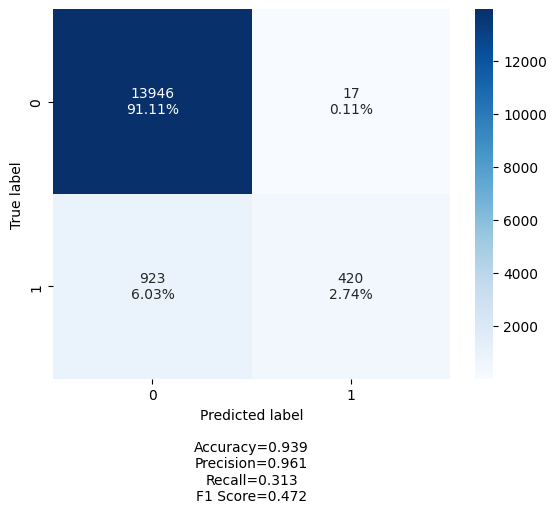

In [16]:
# Performance measures
cf_matrix = confusion_matrix(y_test_all, y_pred_all)
make_confusion_matrix(cf_matrix)

In [17]:
# Inspecting TP by gender
df_tp = get_tp(df_test_all, y_test_all, y_pred_all)

num_tp_fem = df_tp[df_tp[gender_feat]==0].shape[0]
perc_tp_fem = np.round(num_tp_fem / num_fem_test * 100, decimals=2)
num_tp_male = df_tp[df_tp[gender_feat]==1].shape[0]
perc_tp_male = np.round(num_tp_male / num_male_test * 100, decimals=2)

print(f"TP (female): {num_tp_fem}, percentage (all female in test): {perc_tp_fem}")
print(f"TP (male): {num_tp_male}, percentage (all male in test): {perc_tp_male}")

TP (female): 142, percentage (all female in test): 3.07
TP (male): 278, percentage (all male in test): 2.6


In [18]:
# Inspecting FP errors by gender
df_fp = get_fp(df_test_all, y_test_all, y_pred_all)

num_fp_fem = df_fp[df_fp[gender_feat]==0].shape[0]
perc_fp_fem = np.round(num_fp_fem / num_fem_test * 100, decimals=2)
num_fp_male = df_fp[df_fp[gender_feat]==1].shape[0]
perc_fp_male = np.round(num_fp_male / num_male_test * 100, decimals=2)

print(f"FP (female): {num_fp_fem}, percentage (all female in test): {perc_fp_fem}")
print(f"FP (male): {num_fp_male}, percentage (all male in test): {perc_fp_male}")

FP (female): 2, percentage (all female in test): 0.04
FP (male): 15, percentage (all male in test): 0.14


In [19]:
# Inspecting TN by gender
df_tn = get_tn(df_test_all, y_test_all, y_pred_all)
num_tn_fem = df_tn[df_tn[gender_feat]==0].shape[0]
perc_tn_fem = np.round(num_tn_fem / num_fem_test * 100, decimals=2)
num_tn_male = df_tn[df_tn[gender_feat]==1].shape[0]
perc_tn_male = np.round(num_tn_male / num_male_test * 100, decimals=2)

print(f"TN (female): {num_tn_fem}, percentage (all female in test): {perc_tn_fem}")
print(f"TN (male): {num_tn_male}, percentage (all male in test): {perc_tn_male}")

TN (female): 4144, percentage (all female in test): 89.48
TN (male): 9802, percentage (all male in test): 91.82


In [20]:
# Inspecting FN errors by gender
df_fn = get_fn(df_test_all, y_test_all, y_pred_all)
num_fn_fem = df_fn[df_fn[gender_feat]==0].shape[0]
perc_fn_fem = np.round(num_fn_fem / num_fem_test * 100, decimals=2)
num_fn_male = df_fn[df_fn[gender_feat]==1].shape[0]
perc_fn_male = np.round(num_fn_male / num_male_test * 100, decimals=2)

print(f"FN (female): {num_fn_fem}, percentage (all female in test): {perc_fn_fem}")
print(f"FN (male): {num_fn_male}, percentage (all male in test): {perc_fn_male}")

FN (female): 305, percentage (all female in test): 6.59
FN (male): 618, percentage (all male in test): 5.79


### Classifier trained with female data

In [21]:
# Train and test the model with all data
clf = GradientBoostingClassifier(random_state=0)
model_fem = clf.fit(x_train_fem, y_train_fem)
y_pred_fem = model_fem.predict(x_test_fem)

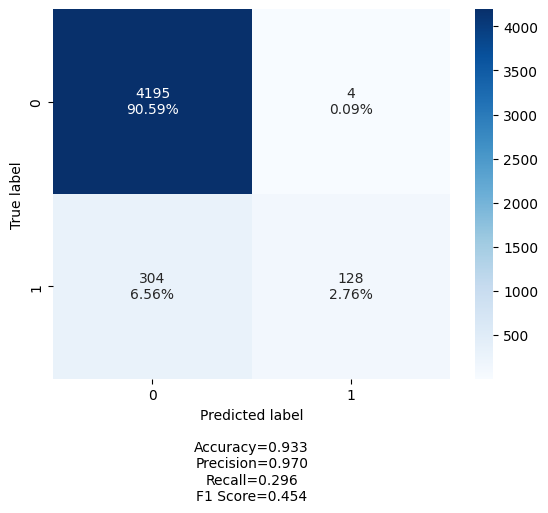

In [22]:
# Performance measures
cf_matrix = confusion_matrix(y_test_fem, y_pred_fem)
make_confusion_matrix(cf_matrix)

### Classifier trained with male data

In [23]:
# Train and test the model with all data
clf = GradientBoostingClassifier(random_state=0)
model_male = clf.fit(x_train_male, y_train_male)
y_pred_male = model_male.predict(x_test_male)

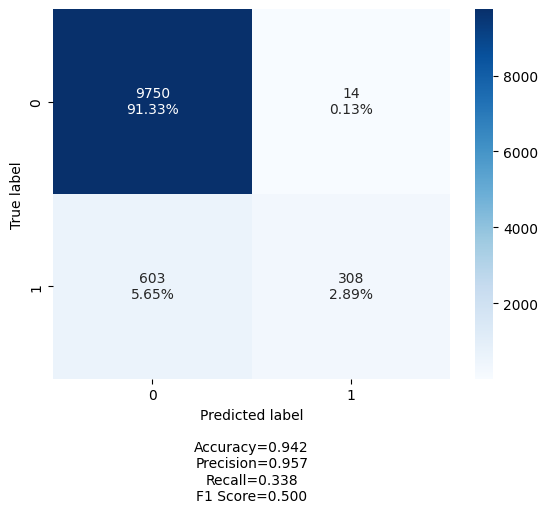

In [24]:
# Performance measures
cf_matrix = confusion_matrix(y_test_male, y_pred_male)
make_confusion_matrix(cf_matrix)

## Explaining models

### Classifier trained with full data

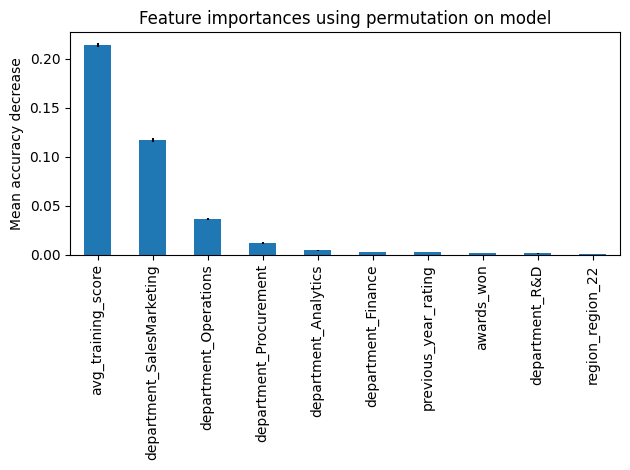

In [25]:
# 10 most important features in the model with full data
make_feature_importance_plot(model_all, x_test_all, y_test_all, model_all.feature_names_in_, 10)

### Classifier trained with female data

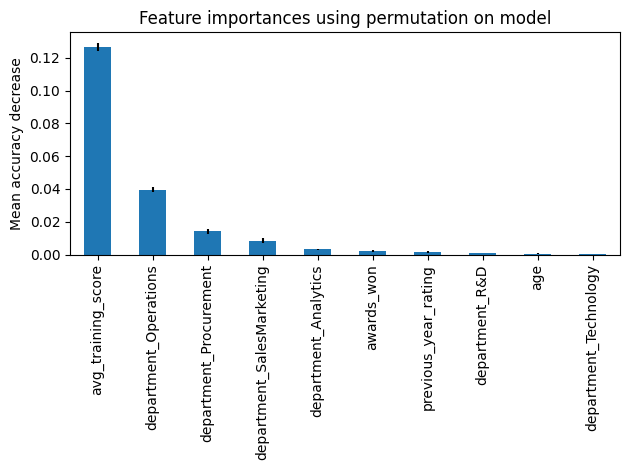

In [26]:
# 10 most important features in the model with female data
make_feature_importance_plot(model_fem, x_test_fem, y_test_fem, model_fem.feature_names_in_, 10)

### Classifier trained with male data

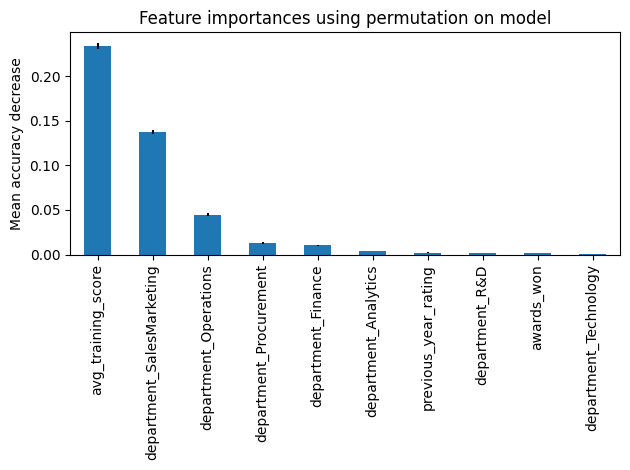

In [27]:
# 10 most important features in the model with female data
make_feature_importance_plot(model_male, x_test_male, y_test_male, model_male.feature_names_in_, 10)

## Explaining predictions

### Classifier trained with all data

In [28]:
# Configure local explainer for the full model
explainer = dx.Explainer(model=model_all, data=x_train_all, y=y_train_all, label="Classifier (all data)")

Preparation of a new explainer is initiated

  -> data              : 31074 rows 56 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 31074 values
  -> model_class       : sklearn.ensemble._gb.GradientBoostingClassifier (default)
  -> label             : Classifier (all data)
  -> predict function  : <function yhat_proba_default at 0x7fb05ee95510> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.00631, mean = 0.0878, max = 0.999
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.801, mean = -2.9e-05, max = 0.992
  -> model_info        : package sklearn

A new explainer has been created!


In [29]:
# Remove target feature from data frames
df_tp.drop([target_feat], axis=1, inplace=True)
df_fp.drop([target_feat], axis=1, inplace=True)
df_tn.drop([target_feat], axis=1, inplace=True)
df_fn.drop([target_feat], axis=1, inplace=True)

In [30]:
# Full model: Female promoted (good prediction)
female_sample = df_tp[df_tp[gender_feat]==0][0:1]
expl = explainer.predict_parts(female_sample, type='break_down')
expl.plot()

In [31]:
# Full model: Female promoted (wrong prediction)
female_sample = df_fp[df_fp[gender_feat]==0][0:1]
expl = explainer.predict_parts(female_sample, type='break_down')
expl.plot()

In [32]:
# Full model: Female non-promoted (good prediction)
female_sample = df_tn[df_tn[gender_feat]==0][0:1]
expl = explainer.predict_parts(female_sample, type='shap')
expl.plot()

In [33]:
# Full model: Female non-promoted (wrong prediction)
female_sample = df_fn[df_fn[gender_feat]==0][0:1]
expl = explainer.predict_parts(female_sample, type='shap')
expl.plot()

In [34]:
# Full model: Male promoted (good prediction)
male_sample = df_tp[df_tp[gender_feat]==1][0:1]
expl = explainer.predict_parts(male_sample, type='break_down')
expl.plot()

In [35]:
# Full model: Male promoted (wrong prediction)
male_sample = df_fp[df_fp[gender_feat]==1][0:1]
expl = explainer.predict_parts(male_sample, type='break_down')
expl.plot()

In [36]:
# Full model: Male non-promoted (good prediction)
male_sample = df_tn[df_tn[gender_feat]==1][0:1]
expl = explainer.predict_parts(male_sample, type='shap')
expl.plot()

In [37]:
# Full model: Male non-promoted (wrong prediction)
male_sample = df_fn[df_fn[gender_feat]==1][0:1]
expl = explainer.predict_parts(male_sample, type='shap')
expl.plot()

### Classifier trained with female data

In [38]:
# Configure local explainer for the female model
explainer = dx.Explainer(model=model_fem, data=x_train_fem, y=y_train_fem, label="Classifier (female data)")

Preparation of a new explainer is initiated

  -> data              : 9402 rows 55 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 9402 values
  -> model_class       : sklearn.ensemble._gb.GradientBoostingClassifier (default)
  -> label             : Classifier (female data)
  -> predict function  : <function yhat_proba_default at 0x7fb05ee95510> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.00272, mean = 0.0934, max = 0.996
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.726, mean = -3.11e-05, max = 0.987
  -> model_info        : package sklearn

A new explainer has been created!


In [39]:
# Distribution of samples for female model
df_fem_tp = get_tp(df_test_fem, y_test_fem, y_pred_fem).drop([target_feat, gender_feat], axis=1)
df_fem_fp = get_fp(df_test_fem, y_test_fem, y_pred_fem).drop([target_feat, gender_feat], axis=1)
df_fem_tn = get_tn(df_test_fem, y_test_fem, y_pred_fem).drop([target_feat, gender_feat], axis=1)
df_fem_fn = get_fn(df_test_fem, y_test_fem, y_pred_fem).drop([target_feat, gender_feat], axis=1)

In [40]:
# Female model: Female promoted (good prediction)
female_sample = df_fem_tp[0:1]
expl = explainer.predict_parts(female_sample, type='break_down')
expl.plot()

In [41]:
# Female model: Female promoted (wrong prediction)
female_sample = df_fem_fp[0:1]
expl = explainer.predict_parts(female_sample, type='break_down')
expl.plot()

In [42]:
# Female model: Female non-promoted (good prediction)
female_sample = df_fem_tn[0:1]
expl = explainer.predict_parts(female_sample, type='shap')
expl.plot()

In [43]:
# Female model: Female non-promoted (wrong prediction)
female_sample = df_fem_fn[0:1]
expl = explainer.predict_parts(female_sample, type='shap')
expl.plot()

### Classifier trained with male data

In [44]:
# Configure explainer
explainer = dx.Explainer(model=model_male, data=x_train_male, y=y_train_male, label="Classifier (male data)")

Preparation of a new explainer is initiated

  -> data              : 21672 rows 55 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 21672 values
  -> model_class       : sklearn.ensemble._gb.GradientBoostingClassifier (default)
  -> label             : Classifier (male data)
  -> predict function  : <function yhat_proba_default at 0x7fb05ee95510> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.00727, mean = 0.0854, max = 0.999
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.737, mean = -3.24e-05, max = 0.99
  -> model_info        : package sklearn

A new explainer has been created!


In [45]:
# Distribution of samples for male model
df_male_tp = get_tp(df_test_male, y_test_male, y_pred_male).drop([target_feat, gender_feat], axis=1)
df_male_fp = get_fp(df_test_male, y_test_male, y_pred_male).drop([target_feat, gender_feat], axis=1)
df_male_tn = get_tn(df_test_male, y_test_male, y_pred_male).drop([target_feat, gender_feat], axis=1)
df_male_fn = get_fn(df_test_male, y_test_male, y_pred_male).drop([target_feat, gender_feat], axis=1)

In [46]:
# Male model: Male promoted (good prediction)
male_sample = df_male_tp[0:1]
expl = explainer.predict_parts(male_sample, type='break_down')
expl.plot()

In [47]:
# Male model: Male promoted (wrong prediction)
male_sample = df_male_fp[0:1]
expl = explainer.predict_parts(male_sample, type='break_down')
expl.plot()

In [48]:
# Male model: Male non-promoted (good prediction)
male_sample = df_male_tn[0:1]
expl = explainer.predict_parts(male_sample, type='shap')
expl.plot()

In [49]:
# Male model: Male non-promoted (wrong prediction)
male_sample = df_male_fn[0:1]
expl = explainer.predict_parts(male_sample, type='shap')
expl.plot()

## Exploring what-if scenarios

### Classifer trained with all data

In [50]:
# Configure DiCE explainer
df_train_dice = x_train_all.copy()
df_train_dice['target'] = y_train_all
features = df_train_dice.columns.to_list()
features.remove('target')
dice_data_all = dice_ml.Data(dataframe=df_train_dice,
                continuous_features = features,
                outcome_name='target')
dice_model_all = dice_ml.Model(model=model_all, backend='sklearn', model_type='classifier')
dice_explainer = dice_ml.Dice(dice_data_all, dice_model_all, method='random')

In [51]:
# Configure some general parameters of the counterfactual generation process
# Number of counterfactuals to generate
num_cfs = 5

# Features that can vary (exclude gender)
features_to_vary = features.copy()
features_to_vary.remove(gender_feat)

In [52]:
# Choose a non-promoted female sample
female_sample = df_tn[df_tn[gender_feat]==0][0:1]

# Do not allow decrease of age
permitted_range = {'age': [female_sample['age'], 65]}

# Generate the counterfactuals
counterfactuals = dice_explainer.generate_counterfactuals(female_sample,
                                  total_CFs=num_cfs,
                                  permitted_range=permitted_range,
                                  features_to_vary=features_to_vary,
                                  random_seed=0)

# Visualize the counterfactuals
counterfactuals.visualize_as_dataframe(show_only_changes=True)   

100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

Query instance (original outcome : 0)


,gender,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,department_Analytics,department_Finance,department_HR,...,region_region_7,region_region_8,region_region_9,education_Bachelors,education_Below Secondary,education_Mastersabove,recruitment_channel_other,recruitment_channel_referred,recruitment_channel_sourcing,target
0,0,1,60,3.0,6,0,57.0,0,0,0,...,0,0,0,1,0,0,1,0,0,0



Diverse Counterfactual set (new outcome: 1.0)


,gender,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,department_Analytics,department_Finance,department_HR,...,region_region_7,region_region_8,region_region_9,education_Bachelors,education_Below Secondary,education_Mastersabove,recruitment_channel_other,recruitment_channel_referred,recruitment_channel_sourcing,target
0,-,-,-,-,-,-,97.2,-,-,-,...,-,-,-,-,-,-,-,-,-,1.0
1,-,-,-,-,-,-,93.1,-,-,-,...,-,-,-,-,-,-,-,-,-,1.0
2,-,-,-,-,35.0,-,96.5,-,-,-,...,-,-,-,-,-,-,-,-,-,1.0
3,-,-,-,-,-,-,86.2,-,-,-,...,-,-,-,-,-,-,-,-,-,1.0
4,-,-,-,-,-,-,82.0,-,-,-,...,-,-,-,-,-,-,-,-,-,1.0


In [53]:
# Get some statistics (number of feature changes and min/max proposed changes)
df_counterfactuals = counterfactuals.cf_examples_list[0].final_cfs_df
female_cfs_stats = counterfactuals_stats(female_sample, df_counterfactuals)
display(female_cfs_stats)

,counterfactual,num_changes,min_feat_change,min_feat_name,max_feat_change,max_feat_name
0,1,2,1.0,region_region_10,40.2,avg_training_score
1,2,1,36.1,avg_training_score,36.1,avg_training_score
2,3,2,29.0,length_of_service,39.5,avg_training_score
3,4,1,29.2,avg_training_score,29.2,avg_training_score
4,5,1,25.0,avg_training_score,25.0,avg_training_score


In [54]:
# See the 10 features more frequently recommended to change
female_cfs_summary = get_summary_changes(female_sample, df_counterfactuals, num_cfs)
display(female_cfs_summary.sort_values('num_changes', ascending=False).head(n=10))

,feature,num_changes,max_difference
6,avg_training_score,5.0,40.2
4,length_of_service,1.0,29.0
17,region_region_10,1.0,1.0
0,gender,0.0,0.0
42,region_region_33,0.0,0.0
32,region_region_24,0.0,0.0
33,region_region_25,0.0,0.0
34,region_region_26,0.0,0.0
35,region_region_27,0.0,0.0
36,region_region_28,0.0,0.0


In [55]:
# Choose a non-promoted male sample
male_sample = df_tn[df_tn[gender_feat]==1][0:1]

# Do not allow decrease of age
permitted_range = {'age': [male_sample['age'], 65]}

# Generate the counterfactuals
counterfactuals = dice_explainer.generate_counterfactuals(male_sample,
                                  total_CFs=num_cfs,
                                  permitted_range=permitted_range,
                                  features_to_vary=features_to_vary,
                                  random_seed=0)

# Visualize the counterfactuals
counterfactuals.visualize_as_dataframe(show_only_changes=True) 

100%|██████████| 1/1 [00:00<00:00,  2.67it/s]

Query instance (original outcome : 0)


,gender,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,department_Analytics,department_Finance,department_HR,...,region_region_7,region_region_8,region_region_9,education_Bachelors,education_Below Secondary,education_Mastersabove,recruitment_channel_other,recruitment_channel_referred,recruitment_channel_sourcing,target
0,1,1,57,3.0,12,0,68.0,0,0,0,...,0,0,0,0,0,1,1,0,0,0



Diverse Counterfactual set (new outcome: 1.0)


,gender,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,department_Analytics,department_Finance,department_HR,...,region_region_7,region_region_8,region_region_9,education_Bachelors,education_Below Secondary,education_Mastersabove,recruitment_channel_other,recruitment_channel_referred,recruitment_channel_sourcing,target
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,1.0
1,-,-,-,-,-,-,93.1,-,-,-,...,-,-,-,-,-,-,-,-,-,1.0
2,-,-,-,-,35.0,-,96.5,-,-,-,...,-,-,-,-,-,-,-,-,-,1.0
3,-,-,-,-,-,-,64.0,-,-,-,...,-,-,-,-,-,-,-,-,-,1.0
4,-,-,-,-,-,-,85.8,-,-,-,...,-,-,-,-,-,-,-,-,-,1.0


In [56]:
# Get some statistics (number of feature changes and min/max proposed changes)
df_counterfactuals = counterfactuals.cf_examples_list[0].final_cfs_df
male_cfs_stats = counterfactuals_stats(male_sample, df_counterfactuals)
display(male_cfs_stats)

,counterfactual,num_changes,min_feat_change,min_feat_name,max_feat_change,max_feat_name
0,1,2,1.0,department_SalesMarketing,1.0,department_SalesMarketing
1,2,1,25.1,avg_training_score,25.1,avg_training_score
2,3,2,23.0,length_of_service,28.5,avg_training_score
3,4,2,1.0,department_SalesMarketing,4.0,avg_training_score
4,5,2,1.0,region_region_15,17.8,avg_training_score


In [57]:
# See the features more frequently recommended to change
male_cfs_summary = get_summary_changes(male_sample, df_counterfactuals, num_cfs)
display(male_cfs_summary.sort_values('num_changes', ascending=False).head(10))

,feature,num_changes,max_difference
6,avg_training_score,4.0,28.5
22,region_region_15,2.0,1.0
14,department_SalesMarketing,2.0,1.0
4,length_of_service,1.0,23.0
0,gender,0.0,0.0
42,region_region_33,0.0,0.0
32,region_region_24,0.0,0.0
33,region_region_25,0.0,0.0
34,region_region_26,0.0,0.0
35,region_region_27,0.0,0.0


In [58]:
# Repeat the process for a greater sample of females (1 counterfactual for each sample)
num_samples = 100
num_cfs = 1
df_female_counterfactuals = pd.DataFrame(columns=df_tn.columns, data=[])
df_female_samples = pd.DataFrame(columns=df_tn.columns, data=[])

# Generate one counterfactual for each sample
for i in range(1, num_samples+1):
    female_sample = df_tn[df_tn[gender_feat]==0][i-1:i]
    permitted_range = {'age': [female_sample['age'], 65]}
    counterfactual = dice_explainer.generate_counterfactuals(female_sample,
                                  total_CFs=num_cfs,
                                  permitted_range=permitted_range,
                                  features_to_vary=features_to_vary,
                                  random_seed=0,
                                  verbose=False)
    df_female_samples = pd.concat([df_female_samples, female_sample])
    df_female_counterfactuals = pd.concat([df_female_counterfactuals, counterfactual.cf_examples_list[0].final_cfs_df])

# Get summary
female_cfs_summary = get_summary_changes(df_female_samples, df_female_counterfactuals, num_cfs)
display(female_cfs_summary.sort_values('num_changes', ascending=False).head(10))

100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


,feature,num_changes,max_difference
6,avg_training_score,61.0,46.5
14,department_SalesMarketing,29.0,1.0
11,department_Operations,15.0,1.0
8,department_Finance,10.0,1.0
33,region_region_25,9.0,1.0
2,age,8.0,30.0
12,department_Procurement,6.0,1.0
17,region_region_10,6.0,1.0
1,no_of_trainings,5.0,2.0
4,length_of_service,4.0,32.0


In [59]:
# Repeat the process for a greater sample of males (1 counterfactual for each sample)
df_male_counterfactuals = pd.DataFrame(columns=df_tn.columns, data=[])
df_male_samples = pd.DataFrame(columns=df_tn.columns, data=[])

# Generate one counterfactual for each sample
for i in range(1, num_samples+1):
    male_sample = df_tn[df_tn[gender_feat]==1][i-1:i]
    permitted_range = {'age': [male_sample['age'], 65]}
    counterfactual = dice_explainer.generate_counterfactuals(male_sample,
                                  total_CFs=num_cfs,
                                  permitted_range=permitted_range,
                                  features_to_vary=features_to_vary,
                                  random_seed=0,
                                  verbose=False)
    df_male_samples = pd.concat([df_male_samples, male_sample])
    df_male_counterfactuals = pd.concat([df_male_counterfactuals, counterfactual.cf_examples_list[0].final_cfs_df])

# Get summary
male_cfs_summary = get_summary_changes(df_male_samples, df_male_counterfactuals, num_cfs)
display(male_cfs_summary.sort_values('num_changes', ascending=False).head(10))

100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


,feature,num_changes,max_difference
6,avg_training_score,66.0,53.2
14,department_SalesMarketing,20.0,1.0
33,region_region_25,13.0,1.0
8,department_Finance,12.0,1.0
17,region_region_10,11.0,1.0
11,department_Operations,10.0,1.0
54,recruitment_channel_referred,8.0,1.0
4,length_of_service,7.0,33.0
12,department_Procurement,4.0,1.0
49,region_region_9,3.0,1.0


### Classifier trained with female data

In [60]:
# Configure DiCE explainer
df_train_dice = x_train_fem.copy()
df_train_dice['target'] = y_train_fem
features = df_train_dice.columns.to_list()
features.remove('target')
dice_data_fem = dice_ml.Data(dataframe=df_train_dice,
                continuous_features = features,
                outcome_name='target')
dice_model_fem = dice_ml.Model(model=model_fem, backend='sklearn', model_type='classifier')
dice_explainer_fem = dice_ml.Dice(dice_data_fem, dice_model_fem, method='random')

In [61]:
# See summary recommendations for a sample of 100 females (one counterfactual for each sample)
df_female_counterfactuals = pd.DataFrame(columns=df_fem_tn.columns, data=[])
df_female_samples = pd.DataFrame(columns=df_fem_tn.columns, data=[])

# Generate one counterfactual for each sample
for i in range(1, num_samples+1):
    female_sample = df_fem_tn[i-1:i]
    permitted_range = {'age': [female_sample['age'], 65]}
    counterfactual = dice_explainer_fem.generate_counterfactuals(female_sample,
                                  total_CFs=num_cfs,
                                  permitted_range=permitted_range,
                                  features_to_vary=features_to_vary,
                                  random_seed=0,
                                  verbose=False)
    df_female_samples = pd.concat([df_female_samples, female_sample])
    df_female_counterfactuals = pd.concat([df_female_counterfactuals, counterfactual.cf_examples_list[0].final_cfs_df])

# Get summary
female_cfs_summary = get_summary_changes(df_female_samples, df_female_counterfactuals, num_cfs)
display(female_cfs_summary.sort_values('num_changes', ascending=False).head(10))

100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


,feature,num_changes,max_difference
5,avg_training_score,79.0,53.5
3,length_of_service,24.0,23.0
34,region_region_27,16.0,1.0
10,department_Operations,12.0,1.0
19,region_region_13,11.0,1.0
16,region_region_10,7.0,1.0
7,department_Finance,7.0,1.0
13,department_SalesMarketing,7.0,1.0
4,awards_won,5.0,1.0
53,recruitment_channel_referred,5.0,1.0


### Classifier trained with male data

In [62]:
# Configure DiCE explainer
df_train_dice = x_train_male.copy()
df_train_dice['target'] = y_train_male
dice_data_male = dice_ml.Data(dataframe=df_train_dice,
                continuous_features = features,
                outcome_name='target')
dice_model_male = dice_ml.Model(model=model_male, backend='sklearn', model_type='classifier')
dice_explainer_male = dice_ml.Dice(dice_data_male, dice_model_male, method='random')

In [63]:
# See summary recommendations for a sample of 100 females (one counterfactual for each sample)
df_male_counterfactuals = pd.DataFrame(columns=df_male_tn.columns, data=[])
df_male_samples = pd.DataFrame(columns=df_male_tn.columns, data=[])

# Generate one counterfactual for each sample
for i in range(1, num_samples+1):
    male_sample = df_male_tn[i-1:i]
    permitted_range = {'age': [male_sample['age'], 65]}
    counterfactual = dice_explainer_male.generate_counterfactuals(male_sample,
                                  total_CFs=num_cfs,
                                  permitted_range=permitted_range,
                                  features_to_vary=features_to_vary,
                                  random_seed=0,
                                  verbose=False)
    df_male_samples = pd.concat([df_male_samples, male_sample])
    df_male_counterfactuals = pd.concat([df_male_counterfactuals, counterfactual.cf_examples_list[0].final_cfs_df])

# Get summary
male_cfs_summary = get_summary_changes(df_male_samples, df_male_counterfactuals, num_cfs)
display(male_cfs_summary.sort_values('num_changes', ascending=False).head(10))

100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


,feature,num_changes,max_difference
5,avg_training_score,65.0,53.5
32,region_region_25,24.0,1.0
7,department_Finance,18.0,1.0
13,department_SalesMarketing,16.0,1.0
10,department_Operations,11.0,1.0
19,region_region_13,7.0,1.0
11,department_Procurement,5.0,1.0
16,region_region_10,5.0,1.0
51,education_Mastersabove,4.0,1.0
42,region_region_34,4.0,1.0
